In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
from scipy import sparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from matplotlib import pyplot as plt 

## Model

In [2]:
def recon_loss(inputs, logits):
    return torch.mean(torch.sum(-logits * inputs, dim=1))

def kl_loss(mu, logvar):
    return torch.mean(0.5 * torch.sum(
        torch.exp(logvar) + mu ** 2 - 1 - logvar, dim=1))

In [3]:
class DisenVAE(nn.Module):
    def __init__(self, M, K, D, tau, dropout):
        super(DisenVAE, self).__init__()

        self.M = M
        self.H = D * 3
        self.D = D
        self.K = K
        self.tau = tau

        self.encoder = nn.Sequential(
            nn.Linear(self.M, self.H),
            nn.Tanh(),
            nn.Linear(self.H, self.D * 2)
        )
        self.items = Parameter(torch.Tensor(self.M, self.D))
        self.cores = Parameter(torch.Tensor(self.K, self.D))
        self.drop = nn.Dropout(dropout)

        init.xavier_normal_(self.items)
        init.xavier_normal_(self.cores)


    def cluster(self):
        items = F.normalize(self.items, dim=1)      # M * D
        cores = F.normalize(self.cores, dim=1)      # K * D
        cates = torch.mm(items, cores.t()) / self.tau
        cates = F.softmax(cates, dim=1)             # M * K
        return items, cores, cates


    def encode(self, X, cates):
        n = X.shape[0]
        X = self.drop(X)
        X = X.view(n, 1, self.M) *  \
            cates.t().expand(n, self.K, self.M)     # n * K * M
        X = X.reshape(n * self.K, self.M)           # (n * K) * M
        h = self.encoder(X)                         # (n * K) * D * 2
        mu, logvar = h[:, :self.D], h[:, self.D:]   # (n * k) * D
        return mu, logvar


    def decode(self, z, items, cates):
        n = z.shape[0] // self.K
        z = F.normalize(z, dim=1)                   # (n * K) * D
        logits = torch.mm(z, items.t()) / self.tau  # (n * K) * M
        probs = torch.exp(logits)                   # (n * K) * M
        probs = torch.sum(probs.view(n, self.K, self.M) * \
                cates.t().expand(n, self.K, self.M), dim=1)
        logits = torch.log(probs)
        logits = F.log_softmax(logits, dim=1)
        return logits


    def sample(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu


    def forward(self, X, A):
        items, cores, cates = self.cluster()
        mu, logvar = self.encode(X, cates)
        z = self.sample(mu, logvar)
        logits = self.decode(z, items, cates)
        return logits, mu, logvar, None, None, None
    

    def loss_fn(self, X, X_logits, X_mu, X_logvar,
                A, A_logits, A_mu, A_logvar, anneal):
        return recon_loss(X, X_logits) + anneal * kl_loss(X_mu, X_logvar)

## Metric

Evaluate function: Normalized discounted cumulative gain (NDCG@k)  Recall@k and Precision@k

In [4]:
def ndcg_kth(outputs, labels, k=100):
    _, preds = torch.topk(outputs, k)               # sorted top k index of outputs
    _, facts = torch.topk(labels, k)                # min(k, labels.nnz(dim=1))
    rows = torch.arange(labels.shape[0]).view(-1, 1)

    tp = 1.0 / torch.log2(torch.arange(2, k + 2).float())
    dcg = torch.sum(tp * labels[rows, preds], dim=1)
    idcg = torch.sum(tp * labels[rows, facts], dim=1)
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0
    return ndcg


def recall_kth(outputs, labels, k=50):
    _, preds = torch.topk(outputs, k, sorted=False) # top k index
    rows = torch.arange(labels.shape[0]).view(-1, 1)

    recall = torch.sum(labels[rows, preds], dim=1) \
           / torch.min(torch.Tensor([k]), torch.sum(labels, dim=1))
    recall[torch.isnan(recall)] = 0
    return recall

def precision_kth(outputs, labels, k=50):
    """
    Compute Precision@k: the proportion of positive class predictions in the top-k predictions
    that are correct.
    
    Args:
    - outputs (torch.Tensor): The model outputs (scores or probabilities) for each class.
    - labels (torch.Tensor): The ground truth labels (binary) for each sample.
    - k (int): The number of top predictions to consider for computing precision.
    
    Returns:
    - torch.Tensor: Precision@k for each sample in the batch.
    """
    # Get the index of the top k highest scoring predictions
    _, preds = torch.topk(outputs, k, sorted=False)  # top k index
    
    # Generate a row index for each sample
    rows = torch.arange(labels.shape[0]).view(-1, 1)

    # Compute Precision@k
    # Get the actual labels by indexing and calculate the number of correct predictions for each sample
    correct_preds = torch.sum(labels[rows, preds], dim=1)
    precision = correct_preds / k
    precision[torch.isnan(precision)] = 0
    
    return precision


## Training/validation data, hyperparameters

Load the pre-processed training and validation data

In [5]:
processed_dataset = r'C:\Users\FOMO\Desktop\Proj\Dataset\Book-Crossing\processed_data'

In [6]:
unique_sid = list()
with open(os.path.join(processed_dataset, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())
n_items = len(unique_sid)

In [7]:
unique_uid = list()
with open(os.path.join(processed_dataset, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
n_users = len(unique_uid)

In [8]:
def load_train_data(csv_file, n_items):
    tp = pd.read_csv(csv_file)
    users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                              (rows, cols)), dtype='float64',
                             shape=(users, n_items))
    return data

In [9]:
train_data = load_train_data(os.path.join(processed_dataset, 'train.csv'), n_items)

In [10]:
def load_tr_te_data(csv_file_tr, csv_file_te, n_items):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                 (rows_tr, cols_tr)), dtype='float64',
                                shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                 (rows_te, cols_te)), dtype='float64',
                                shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [11]:
vad_data_tr, vad_data_te = load_tr_te_data(
        os.path.join(processed_dataset, 'validation_tr.csv'),
        os.path.join(processed_dataset, 'validation_te.csv'),
        n_items)

In [12]:
tst_data_tr, tst_data_te = load_tr_te_data(
        os.path.join(processed_dataset, 'test_tr.csv'),
        os.path.join(processed_dataset, 'test_te.csv'),
        n_items)

In [13]:
assert n_items == train_data.shape[1]
assert n_items == vad_data_tr.shape[1]
assert n_items == vad_data_te.shape[1]
assert n_items == tst_data_tr.shape[1]
assert n_items == tst_data_te.shape[1]

Set up training hyperparameters

In [14]:
lr = 1e-3
weight_decay = 1e-4 # weight decay coefficient
dropout = 0.5
beta = 0.3
kfac = 7
dfac = 200
tau = 0.1
batch_size = 100
epochs = 50
total_anneal_steps = 100000 # the total number of gradient updates for annealing
anneal_cap = 0.2 
seed = 98765 # random seed
log_interval = 100
save = r'C:\Users\FOMO\Desktop\Proj\BookRS\Save_MacridVAE\Book-Crossing\model.pt' # path to save the final model

## Build the model

In [15]:
torch.manual_seed(seed) # Set the random seed manually for reproductibility.
device = torch.device("cuda:0")

In [16]:
def load_net(model, N, M, K, D, tau, dropout):
    if model == 'DisenVAE':
        return DisenVAE(M, K, D, tau, dropout)

In [17]:
net = load_net('DisenVAE', n_users, n_items, kfac, dfac, 
               tau, dropout)
net.to(device)

DisenVAE(
  (encoder): Sequential(
    (0): Linear(in_features=107813, out_features=600, bias=True)
    (1): Tanh()
    (2): Linear(in_features=600, out_features=400, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
)

In [18]:
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion = net.loss_fn

### Train a MacridVAE

In [19]:
ndcg100_values = []

empty_data = sparse.csr_matrix(train_data.shape, dtype=float)
tr_data = sparse.vstack([train_data, vad_data_tr, tst_data_tr])
te_data = sparse.vstack([empty_data, vad_data_te, tst_data_te])

n_train = train_data.shape[0]
n_valid = vad_data_tr.shape[0]
n_test  = tst_data_tr.shape[0]
train_idx = range(n_train)
valid_idx = range(n_train, n_train + n_valid)
test_idx  = range(n_train + n_valid, n_train + n_valid + n_test)

n_batches = int(np.ceil(n_train / batch_size))
update = 0
anneals = 500 * n_batches
best_n100 = 0.0

In [20]:
def evaluate(net, idx):
    net.eval()
    n_test = len(idx)
    metrics = {'ndcg': {}, 'recall': {}, 'precision': {}}
    ks = [5, 10, 20, 50, 100]

    # Initialising the metrics store
    for k in ks:
        metrics['ndcg'][k] = []
        metrics['recall'][k] = []
        metrics['precision'][k] = []

    with torch.no_grad():
        for start_idx in range(0, n_test, batch_size):
            end_idx = min(start_idx + batch_size, n_test)
            X_tr = tr_data[idx[start_idx: end_idx]]
            X_te = te_data[idx[start_idx: end_idx]]
            X_tr = torch.Tensor(X_tr.toarray()).to(device)
            X_te = torch.Tensor(X_te.toarray())
            A = None
            X_tr_logits, _, _, _, _, _ = net(X_tr, A)

            X_tr_logits[torch.nonzero(X_tr, as_tuple=True)] = float('-inf')
            X_tr_logits = X_tr_logits.cpu()

            # Calculation of indicators
            for k in ks:
                metrics['ndcg'][k].append(ndcg_kth(X_tr_logits, X_te, k=k))
                metrics['recall'][k].append(recall_kth(X_tr_logits, X_te, k=k))
                metrics['precision'][k].append(precision_kth(X_tr_logits, X_te, k=k))

    # Converting a list of indicators to an average
    for metric in metrics:
        for k in ks:
            metrics[metric][k] = torch.mean(torch.cat(metrics[metric][k])).item()

    return metrics

In [21]:
try:
    for epoch in range(epochs):
        epoch_start_time = time.time()

        net.train()
        running_loss = 0.0
        t = time.time()
        
        train_idx = np.random.permutation(train_idx)
        
        for start_idx in range(0, n_train, batch_size):
            end_idx = min(start_idx + batch_size, n_train)
            X = train_data[train_idx[start_idx: end_idx]]
            X = torch.Tensor(X.toarray()).to(device)  # users-items matrix
            A = None
            optimizer.zero_grad()
            X_logits, X_mu, X_logvar, A_logits, A_mu, A_logvar = net(X, A)
            anneal = min(beta, update / anneals)
            loss = criterion(X, X_logits, X_mu, X_logvar, A, A_logits, A_mu, A_logvar, anneal)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            update += 1
        
        print('[%3d] loss: %.3f' % (epoch, running_loss / n_batches), end='\t', flush=True)
        # Evaluation 
        metrics = evaluate(net, valid_idx)
        ndcg100_values.append(metrics['ndcg'][100]) 
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:4.2f}s | '
            'ndcg@100 {:5.3f} | recall@20 {:5.3f} | recall@50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, 
                metrics['ndcg'][100], metrics['recall'][20], metrics['recall'][50]))
        print('-' * 89)

        # Save the model if the n100 is the best we've seen so far.
        if metrics['ndcg'][100] > best_n100:
            with open(save, 'wb') as f:
                torch.save(net, f)
            best_n100 = metrics['ndcg'][100]    


except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(save, 'rb') as f:
    model = torch.load(f)

[  0] loss: 465.015	-----------------------------------------------------------------------------------------
| end of epoch   0 | time: 16.93s | ndcg@100 0.016 | recall@20 0.015 | recall@50 0.032
-----------------------------------------------------------------------------------------
[  1] loss: 450.745	-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 15.17s | ndcg@100 0.028 | recall@20 0.027 | recall@50 0.052
-----------------------------------------------------------------------------------------
[  2] loss: 437.836	-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 15.44s | ndcg@100 0.027 | recall@20 0.028 | recall@50 0.048
-----------------------------------------------------------------------------------------
[  3] loss: 426.619	-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 15

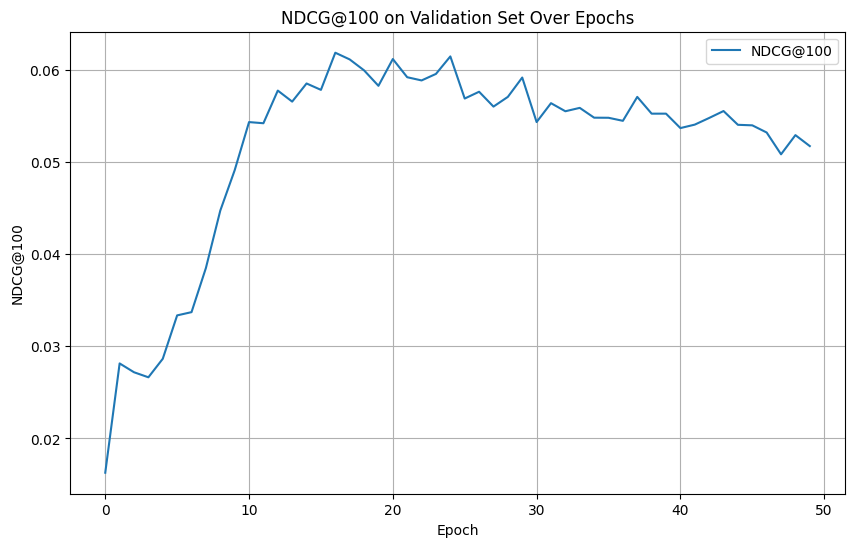

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(ndcg100_values, label='NDCG@100')
plt.xlabel('Epoch')
plt.ylabel('NDCG@100')
plt.title('NDCG@100 on Validation Set Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Evaluate

In [23]:
# Run on test data.
metrics = evaluate(net, test_idx)

print('=' * 89)
print('| End of training |')
for k in [5, 10, 20, 50, 100]:
    print('| ndcg@{} {:5.3f} | recall@{} {:5.3f} | precision@{} {:5.3f}'.format(
        k, metrics['ndcg'][k], k, metrics['recall'][k], k, metrics['precision'][k]))
print('=' * 89)

| End of training |
| ndcg@5 0.031 | recall@5 0.032 | precision@5 0.020
| ndcg@10 0.033 | recall@10 0.039 | precision@10 0.015
| ndcg@20 0.037 | recall@20 0.052 | precision@20 0.010
| ndcg@50 0.047 | recall@50 0.088 | precision@50 0.007
| ndcg@100 0.052 | recall@100 0.110 | precision@100 0.005
